# Imports, Custom Functions & Data Loading

## Import libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import spacy 

from collections import Counter, defaultdict
from transformers import AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from tqdm import tqdm

from sklearn.metrics import f1_score

# spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

# Ignore RuntimeWarning and UserWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Define functions

In [9]:
def preprocess(text):
    
    # remove URLs
    text = re.sub('http\S*', ' ', text)
    
    # remove non-alphabetic
    text = re.sub("[^a-zA-Z]", " ", text)
    
    # make lowercase
    text = text.lower()

    # remove one character word
    text = re.sub("\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub("^[a-zA-Z]\s+", '', text)
    
    # replace double space to one space
    text = re.sub("\s+", ' ', text)
    
    # tokenize, lemmatize, remove stop words
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(text)


class BPE():
    """Byte-Pair Encoding: Subword-based tokenization algorithm."""
    
    def __init__(self, corpus, vocab_size):
        """Initialize BPE tokenizer."""
        self.corpus = corpus
        self.vocab_size = vocab_size
        
        # pre-tokenize the corpus into words, BERT pre-tokenizer is used here
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.word_freqs = defaultdict(int)
        self.splits = {}
        self.merges = {}
    
    
    def train(self):
        """Train BPE tokenizer."""
    # (1) Compute the frequencies of each word in the corpus
    # (2) Compute the base vocabulary of all characters in the corpus
    # (3) Split each word into individual characters before training
    # (4) Merge the most frequent pair iteratively until the vocabulary size is reached

        # compute the frequencies of each word in the corpus
        for text in self.corpus:
            words_with_offsets = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
            new_words = [word for word, offset in words_with_offsets]
            for word in new_words:
                self.word_freqs[word] += 1

        # compute the base vocabulary of all characters in the corpus
        alphabet = []
        for word in self.word_freqs.keys():
            for letter in word:
                if letter not in alphabet:
                    alphabet.append(letter)
        alphabet.sort()

        # add the special token </w> at the beginning of the vocabulary
        vocab = ["</w>"] + alphabet.copy()

        # split each word into individual characters before training
        self.splits = {word: [c for c in word] for word in self.word_freqs.keys()}

        # merge the most frequent pair iteratively until the vocabulary size is reached
        while len(vocab) < self.vocab_size:

            # compute the frequency of each pair
            pair_freqs = self.compute_pair_freqs()

            # find the most frequent pair
            best_pair = ""
            max_freq = None
            for pair, freq in pair_freqs.items():
                if max_freq is None or max_freq < freq:
                    best_pair = pair
                    max_freq = freq

            # merge the most frequent pair
            self.splits = self.merge_pair(*best_pair)
            self.merges[best_pair] = best_pair[0] + best_pair[1]
            vocab.append(best_pair[0] + best_pair[1])
        return self.merges


    def compute_pair_freqs(self):
        """Compute the frequency of each pair."""

        pair_freqs = defaultdict(int)
        for word, freq in self.word_freqs.items():
            split = self.splits[word]
            if len(split) == 1:
                continue
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                pair_freqs[pair] += freq
        return pair_freqs


    def merge_pair(self, a, b):
        """Merge the given pair."""

        for word in self.word_freqs:
            split = self.splits[word]
            if len(split) == 1:
                continue
            i = 0
            while i < len(split) - 1:
                if split[i] == a and split[i + 1] == b:
                    split = split[:i] + [a + b] + split[i + 2 :]
                else:
                    i += 1
            self.splits[word] = split
        return self.splits
    

    def tokenize(self, text):
        """Tokenize a given text with trained BPE tokenizer (including pre-tokenization, split, and merge)."""
        
        pre_tokenize_result = self.tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
        pre_tokenized_text = [word for word, offset in pre_tokenize_result]
        splits_text = [[l for l in word] for word in pre_tokenized_text]

        for pair, merge in self.merges.items():
            for idx, split in enumerate(splits_text):
                i = 0
                while i < len(split) - 1:
                    if split[i] == pair[0] and split[i + 1] == pair[1]:
                        split = split[:i] + [merge] + split[i + 2 :]
                    else:
                        i += 1
                splits_text[idx] = split
        result = sum(splits_text, [])
        return result
    

def get_tfidf_matrix(df, vectorizer):
    
    # Convert the TF-IDF matrix to a dense NumPy array
    matrix = df.todense()

    # Convert the dense matrix to a DataFrame
    matrix = pd.DataFrame(matrix, columns=vectorizer.get_feature_names_out())

    return matrix


# The sequences being in the formar ['word1', 'word2', 'word3', ...], preprocess it
def string2embedding_idx(text_sequence, model):

    sequence = []
    for token in text_sequence:
        try:
            sequence.append(model.wv.key_to_index[token])
        except:
            sequence.append(2899)

    return sequence


def TSNE_10ClosestWords(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0, perplexity = 10)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    

class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, df, word2vec_model):
        self.df = df
        self.word2vec_model = word2vec_model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx, -1 if self.word2vec_model == 'skipgram' else -2]
        label = self.df.iloc[idx, 1]

        # Convert sequence to a 1D tensor
        sequence_tensor = torch.tensor(sequence, dtype=torch.long)

        # Convert label to a 1D tensor (scalar)
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)

        return sequence_tensor, label_tensor


def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device


def train(model, train_loader, test_loader, optimizer, loss_func, epochs, device, **kwargs):
    """
    Trains a neural network model.

    Args:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training.
    - loss_func (torch.nn.Module): The loss function used for training.
    - epochs (int): Number of training epochs.
    - device (torch.device): The device on which the training will be performed.
    - **kwargs: Additional arguments for customization.

    Returns:
    - train_loss_hist (list): List containing training loss values for each epoch.
    - train_acc_hist (list): List containing training accuracy values for each epoch.
    """

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('======== Training phase ========')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (output > 0.5).float()
            correct_batch = (predicted == target).sum().item()
            mini_batch_size = target.size(0)
            accuracy_batch = 100 * correct_batch / mini_batch_size

            # Compute F1-score
            f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

            total += mini_batch_size
            correct += correct_batch
            # Append targets and predictions to the lists
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            pbar.set_description(
                f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
            )

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        train_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print(f'Training F1-Score = {train_f1_score:.2f}%')

        # Evaluate the model on the validation set
        print('======== Validation phase ========')
        model.eval()
        test_loss = 0.
        total = 0.
        correct = 0.
        # Lists to store targets and predictions
        all_targets = []
        all_predictions = []

        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        with torch.no_grad():
            for batch_idx, (data, target) in pbar:
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = loss_fn(output, target)

                test_loss += loss.item()

                predicted = (output > 0.5).float()
                correct_batch = (predicted == target).sum().item()
                mini_batch_size = target.size(0)
                accuracy_batch = 100 * correct_batch / mini_batch_size

                # Compute F1-score
                f1_score_batch = 100 * f1_score(target.cpu().numpy(), predicted.cpu().numpy(), average='binary')

                total += mini_batch_size
                correct += correct_batch
                # Append targets and predictions to the lists
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.set_description(
                    f'Loss = {loss:.4f} | Accuracy = {accuracy_batch:.2f}% | F1-Score = {f1_score_batch:.2f}% | Batch ID = {batch_idx + 1} '
                )

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        all_targets = np.array(all_targets)
        all_predictions = np.array(all_predictions)
        test_f1_score = 100 * f1_score(all_targets, all_predictions, average='binary')

        print(f'Test Cross-Entropy Loss = {test_loss:.4f}')
        print(f'Test Accuracy = {test_accuracy:.2f}%')
        print(f'Test F1-Score = {test_f1_score:.2f}%')
        print()

        train_loss_lst.append(train_loss)
        train_f1_lst.append(train_f1_score)
        test_loss_lst.append(test_loss)
        test_f1_lst.append(test_f1_score)

    return train_loss_lst, train_f1_lst, test_loss_lst, test_f1_lst

# LSTM model with pre-trained Word2Vec embeddings
class CustomLSTM(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output


# GRU model with pre-trained Word2Vec embeddings
class CustomGRU(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(embeddings = torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        output = self.fc(output[:, -1, :])  # Use the last time step's output
        return output
    

# GRU model with pre-trained Word2Vec embeddings and attention mechanism
class CustomGRU_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomGRU_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.gru = torch.nn.GRU(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output


# LSTM model with pre-trained Word2Vec embeddings and attention mechanism
class CustomLSTM_Attention(torch.nn.Module):
    def __init__(self, word2vec_model, hidden_size, output_size, num_layers = 1, bidirectional = False, freeze_embeddings = True):
        super(CustomLSTM_Attention, self).__init__()
        self.embedding_dim = word2vec_model.vector_size
        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.lstm = torch.nn.LSTM(self.embedding_dim, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional)
        self.fc = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), output_size)
        self.attention = torch.nn.Linear(hidden_size * (2 if bidirectional else 1), 1)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        attention_weights = torch.nn.functional.softmax(self.attention(output), dim = 1)
        output = torch.sum(attention_weights * output, dim = 1)
        output = self.fc(output)
        return output
    

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.positional_encoding = torch.zeros((1, max_len, d_model))
        self.positional_encoding[0, :, 0::2] = torch.sin(position * div_term)
        self.positional_encoding[0, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x):
        return x + self.positional_encoding[:, :x.size(1), :]


class TransformerEncoder(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True):
        super(TransformerEncoder, self).__init__()

        self.embedding = torch.nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.wv.vectors), freeze = freeze_embeddings)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_len)
        
        self.transformer_encoder_layer = torch.nn.TransformerEncoderLayer(
                                                                          d_model=embedding_dim,
                                                                          nhead=num_heads,
                                                                          dim_feedforward=hidden_dim,
                                                                          dropout=dropout
                                                                          )
        self.transformer_encoder = torch.nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)  # Change from (batch_size, seq_len, embedding_dim) to (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Change back to (batch_size, seq_len, embedding_dim)
        return x
    

class TransformerEncoderForClassification(torch.nn.Module):
    def __init__(self, word2vec_model, embedding_dim, num_heads, hidden_dim, num_layers, max_len=512, dropout=0.1, freeze_embeddings = True, num_classes=1):
        super(TransformerEncoderForClassification, self).__init__()

        self.embedding_dim = embedding_dim
        self.encoder = TransformerEncoder(word2vec_model, num_heads, hidden_dim, num_layers, max_len, dropout, freeze_embeddings)
        
        # Classification head
        self.fc = torch.nn.Linear(self.embedding_dim, num_classes)

    def forward(self, x):
        encoder_output = self.encoder(x)
        
        # Global average pooling along the sequence dimension
        pooled_output = torch.nn.functional.adaptive_avg_pool1d(encoder_output.permute(0, 2, 1), 1).squeeze(-1)
        
        # Classification head
        logits = self.fc(pooled_output)

        return logits
    

# FCNN model to be used with the TF-IDF features
class CustomFCNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomFCNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Data Loading

In [10]:
tweets_train = pd.read_csv('../data/tweets_data/train.csv')[['text', 'target']].reset_index(drop=True)
tweets_test = pd.read_csv('../data/tweets_data/test.csv')[['id', 'text']]
tweets_labels = pd.read_csv('../data/tweets_data/test_labels.csv', encoding='latin-1')[['choose_one', 'text']]

tweets_labels['target'] = (tweets_labels['choose_one']=='Relevant').astype(int)
tweets_labels['id'] = tweets_labels.index

tweets_test = pd.merge(left = tweets_test, right = tweets_labels, on='id', how = 'left')[['id', 'text_x', 'target']]
tweets_test.rename(columns={'text_x': 'text'}, inplace=True)
tweets_test = tweets_test[['text', 'target']]

print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1



Testing data


,text,target
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1


# Text pre-processing

## Cleaning text using key-words and lemmatization

In [11]:
tweets_train['clean_text'] = tweets_train['text'].apply(preprocess)
tweets_test['clean_text'] = tweets_test['text'].apply(preprocess)

In [12]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...



Testing data


,text,target,clean_text
0,Just happened a terrible car crash,1,happen terrible car crash
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan


## Sub-word tokenization with BERT Tokenizer for Byte-Pair Encoding 

In [13]:
# set the hyperparameter of vocabulary size
vocab_size = 3000
corpus = tweets_train['clean_text'].tolist()

# create a BPE tokenizer object
MyBPE = BPE(corpus=corpus, vocab_size=vocab_size)

# train BPE tokenizer with Wikipedia corpus
MyBPE.train()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

C:\Python\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tfrod\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{('e', 'r'): 'er',
 ('r', 'e'): 're',
 ('i', 'n'): 'in',
 ('a', 'n'): 'an',
 ('o', 'n'): 'on',
 ('s', 't'): 'st',
 ('a', 't'): 'at',
 ('a', 'r'): 'ar',
 ('a', 'l'): 'al',
 ('o', 'r'): 'or',
 ('e', 'n'): 'en',
 ('l', 'e'): 'le',
 ('l', 'i'): 'li',
 ('d', 'e'): 'de',
 ('i', 'c'): 'ic',
 ('s', 'e'): 'se',
 ('a', 'm'): 'am',
 ('r', 'o'): 'ro',
 ('l', 'o'): 'lo',
 ('i', 'l'): 'il',
 ('a', 'c'): 'ac',
 ('i', 't'): 'it',
 ('s', 'h'): 'sh',
 ('u', 'n'): 'un',
 ('c', 'h'): 'ch',
 ('c', 'o'): 'co',
 ('u', 'r'): 'ur',
 ('v', 'e'): 've',
 ('t', 'h'): 'th',
 ('r', 'a'): 'ra',
 ('i', 'on'): 'ion',
 ('g', 'e'): 'ge',
 ('i', 's'): 'is',
 ('m', 'e'): 'me',
 ('in', 'g'): 'ing',
 ('a', 'y'): 'ay',
 ('k', 'e'): 'ke',
 ('n', 'e'): 'ne',
 ('a', 'd'): 'ad',
 ('r', 'i'): 'ri',
 ('h', 'o'): 'ho',
 ('o', 'd'): 'od',
 ('s', 's'): 'ss',
 ('at', 'e'): 'ate',
 ('en', 't'): 'ent',
 ('e', 'l'): 'el',
 ('a', 'p'): 'ap',
 ('f', 'i'): 'fi',
 ('l', 'y'): 'ly',
 ('t', 'er'): 'ter',
 ('o', 'm'): 'om',
 ('g', 'h'): 'gh',
 (

In [15]:
tweets_train['tokenized_text'] = tweets_train['clean_text'].apply(lambda x: MyBPE.tokenize(x))
tweets_test['tokenized_text'] = tweets_test['clean_text'].apply(lambda x: MyBPE.tokenize(x))

In [16]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or..."
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...,"[get, send, photo, ru, by, alaska, smoke, wild..."



Testing data


,text,target,clean_text,tokenized_text
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, ter, rible, car, crash]"
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]"
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]"
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]"


## Convert Text into Input Features

### TF-IDF

In [17]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(tweets_train['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_train['TFIDF'] = X_train.toarray().tolist()

X_test = vectorizer.transform(tweets_test['tokenized_text'].apply(lambda tokens: ' '.join(tokens)))
# Add a new column 'TFIDF' to the original DataFrame with the TF-IDF arrays
tweets_test['TFIDF'] = X_test.toarray().tolist()

In [18]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, canada]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...,"[get, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



Testing data


,text,target,clean_text,tokenized_text,TFIDF
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, ter, rible, car, crash]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Word2Vec (CBOW and Skip-Gram)

In [19]:
print('Maximum length of tokenized text in training data:', max([len(sent) for sent in tweets_train['tokenized_text']]))
print('Maximum length of tokenized text in testing data:', max([len(sent) for sent in tweets_test['tokenized_text']]))

Maximum length of tokenized text in training data: 42
Maximum length of tokenized text in testing data: 50


In [20]:
# Train Word2Vec model
cbow_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 128, window = 10, min_count = 1, workers = 4, sg = 0, epochs = 64)
# Add the <pad> token to the cbow_model so that the last token is the <pad> token
cbow_model.wv.key_to_index['<pad>'] = len(cbow_model.wv)
# Add the embedding of <pad> token to the cbow_model
cbow_model.wv.vectors = np.append(cbow_model.wv.vectors, np.zeros((1, 128)), axis=0)


skipgram_model = Word2Vec(sentences = tweets_train['tokenized_text'], vector_size = 128, window = 10, min_count = 1, workers = 4, sg = 1, epochs = 64)
# Add the <pad> token to the skipgram_model so that the last token is the <pad> token
skipgram_model.wv.key_to_index['<pad>'] = len(skipgram_model.wv)
# Add the embedding of <pad> token to the skipgram_model
skipgram_model.wv.vectors = np.append(skipgram_model.wv.vectors, np.zeros((1, 128)), axis=0)

# Add the <pad> token to all the tokenized text until the length of each tokenized text is 50
tweets_train['tokenized_text'] = tweets_train['tokenized_text'].apply(lambda tokens: tokens + ['<pad>'] * (50 - len(tokens)))
tweets_test['tokenized_text'] = tweets_test['tokenized_text'].apply(lambda tokens: tokens + ['<pad>'] * (50 - len(tokens)))

# Apply the string2embedding_idx function to create a new column
tweets_train['CBOW_sequences'] = tweets_train['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_train['SkipGram_sequences'] = tweets_train['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))
tweets_test['CBOW_sequences'] = tweets_test['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, cbow_model))
tweets_test['SkipGram_sequences'] = tweets_test['tokenized_text'].apply(lambda tokens: string2embedding_idx(tokens, skipgram_model))

In [21]:
print('Training data')
display(tweets_train.head())
print()
print('Testing data')
display(tweets_test.head())

Training data


,text,target,clean_text,tokenized_text,TFIDF,CBOW_sequences,SkipGram_sequences
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[de, ed, reason, earthquake, allah, for, give,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[30, 63, 851, 428, 2384, 427, 452, 2899, 2899,...","[30, 63, 851, 428, 2384, 427, 452, 2899, 2899,..."
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ron, ge, s, ask, cana...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[305, 16, 393, 74, 697, 129, 0, 623, 1615, 289...","[305, 16, 393, 74, 697, 129, 0, 623, 1615, 289..."
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[resident, ask, shel, ter, place, not, ify, of...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1803, 623, 1802, 105, 672, 223, 2503, 664, 43...","[1803, 623, 1802, 105, 672, 223, 2503, 664, 43..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...,"[people, re, ce, ive, wildfire, evacuation, or...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[56, 7, 113, 351, 238, 437, 449, 134, 2899, 28...","[56, 7, 113, 351, 238, 437, 449, 134, 2899, 28..."
4,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfire pour...,"[get, send, photo, ru, by, alaska, smoke, wild...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[53, 443, 264, 421, 654, 2446, 446, 238, 175, ...","[53, 443, 264, 421, 654, 2446, 446, 238, 175, ..."



Testing data


,text,target,clean_text,tokenized_text,TFIDF,CBOW_sequences,SkipGram_sequences
0,Just happened a terrible car crash,1,happen terrible car crash,"[happen, ter, rible, car, crash, <pad>, <pad>,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[416, 106, 2577, 74, 76, 2899, 2899, 2899, 289...","[416, 106, 2577, 74, 76, 2899, 2899, 2899, 289..."
1,"Heard about #earthquake is different cities, s...",1,hear earthquake different city stay safe,"[hear, earthquake, different, city, stay, safe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[257, 432, 1651, 235, 747, 1189, 2899, 2899, 2...","[257, 432, 1651, 235, 747, 1189, 2899, 2899, 2..."
2,"there is a forest fire at spot pond, geese are...",1,forest fire spot pond goose flee street save,"[forest, fire, spot, p, ond, go, ose, fle, e, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[306, 16, 962, 12, 1500, 29, 2831, 1162, 8, 76...","[306, 16, 962, 12, 1500, 29, 2831, 1162, 8, 76..."
3,Apocalypse lighting. #Spokane #wildfires,1,apocalypse lighting spokane wildfire,"[apocalypse, light, ing, spo, k, ane, wildfire...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[720, 294, 19, 1455, 21, 748, 236, 2899, 2899,...","[720, 294, 19, 1455, 21, 748, 236, 2899, 2899,..."
4,Typhoon Soudelor kills 28 in China and Taiwan,1,typhoon soudelor kill china taiwan,"[typhoon, soudelor, kill, china, taiwan, <pad>...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[385, 986, 63, 569, 1776, 2899, 2899, 2899, 28...","[385, 986, 63, 569, 1776, 2899, 2899, 2899, 28..."


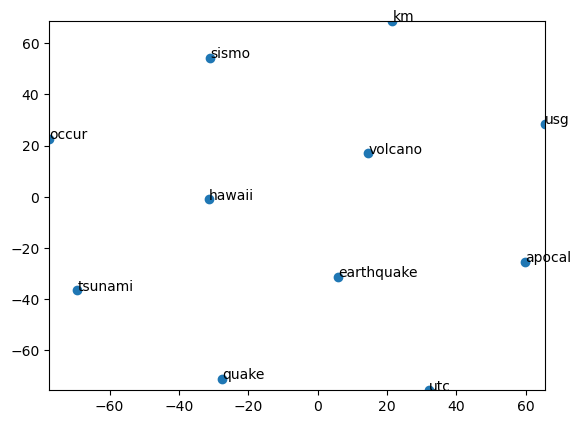

In [22]:
TSNE_10ClosestWords(cbow_model, 'earthquake', 128)

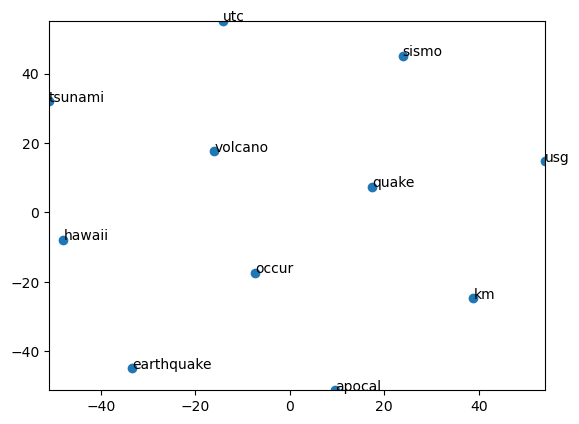

In [23]:
TSNE_10ClosestWords(skipgram_model, 'earthquake', 128)

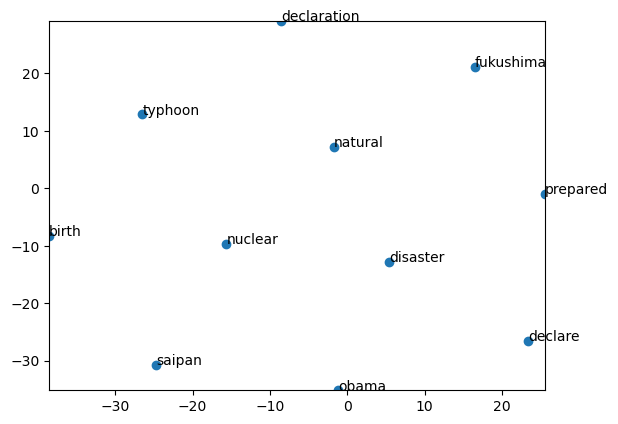

In [24]:
TSNE_10ClosestWords(cbow_model, 'disaster', 128)

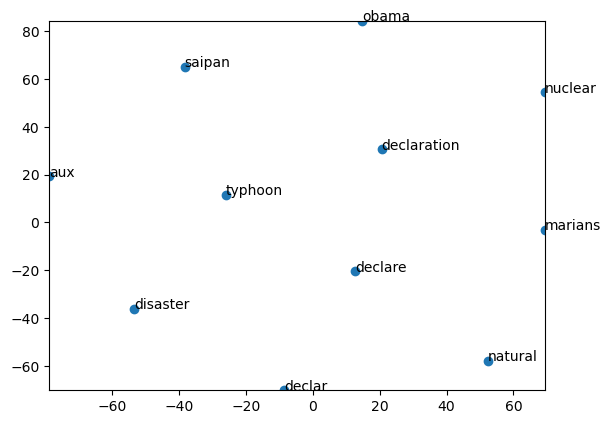

In [25]:
TSNE_10ClosestWords(skipgram_model, 'disaster', 128)

# Loading and Testing our Pre-Trained Embeddings to the PyTorch's Embedding layer

In [26]:
# create embedding layer with pre-trained weights
pretrained_embeddings_layer = torch.nn.Embedding.from_pretrained(torch.FloatTensor(skipgram_model.wv.vectors))
# check weights of the pre-trained embedding layer
pretrained_embeddings_layer.weight

Parameter containing:
tensor([[ 0.0882, -0.0341,  0.2267,  ..., -0.0203, -0.1459,  0.1309],
        [ 0.0530, -0.0222,  0.0293,  ..., -0.2616,  0.0510, -0.0338],
        [ 0.1325,  0.0830,  0.1114,  ...,  0.1339,  0.2523,  0.0573],
        ...,
        [ 0.1262, -0.0567,  0.1004,  ..., -0.1551, -0.0092, -0.3114],
        [ 0.1242, -0.1364,  0.3965,  ..., -0.2474,  0.2938, -0.1727],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [27]:
TrainTweetsDataset = TweetsDataset(tweets_train, 'skipgram')
TrainTweetsDataset[0]

(tensor([  30,   63,  851,  428, 2384,  427,  452, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899, 2899,
         2899, 2899]),
 tensor([1.]))

In [28]:
sequence = TrainTweetsDataset[0][0]
sequence_embeddings = pretrained_embeddings_layer(sequence)

print('Embedding of the first token:          {}'.format(sequence_embeddings[0]))
print('Embedding of the second token:         {}'.format(sequence_embeddings[1]))
print('Embedding of the third token:          {}'.format(sequence_embeddings[2]))
print('Embedding of the fourth token:         {}'.format(sequence_embeddings[3]))
print('Embedding of the fifth token:          {}'.format(sequence_embeddings[4]))
print('Embedding of the sixth token:          {}'.format(sequence_embeddings[5]))
print('Embedding of the twenty-fifth token:   {}'.format(sequence_embeddings[24]))
print('Embedding of the fortieth token:       {}'.format(sequence_embeddings[39]))
print('Embedding of the fiftieth token:       {}'.format(sequence_embeddings[49]))

Embedding of the first token:          tensor([ 2.0343e-04,  4.4073e-02,  8.0631e-02,  9.8091e-02,  2.6482e-01,
        -4.9104e-01, -1.6058e-01,  6.4141e-02,  1.6967e-01,  2.1140e-01,
        -3.2395e-01, -1.0534e-01, -1.6323e-01, -1.9625e-01,  1.6502e-01,
        -2.9644e-01, -2.7382e-01, -1.6795e-01, -1.9871e-01,  1.4754e-01,
         2.8859e-01,  2.2557e-01,  1.2598e-01, -2.1040e-01, -2.1837e-01,
         1.0105e-01, -4.2532e-01,  6.2930e-02, -3.3507e-01,  3.2998e-01,
        -3.1590e-01,  8.6326e-02, -1.6227e-01,  1.0555e-01, -2.9731e-01,
        -1.6574e-01, -1.0054e-01,  3.8479e-01,  1.8117e-01, -2.6420e-01,
        -2.0678e-01, -1.5877e-01, -3.9262e-02, -9.1168e-02, -2.4678e-01,
         1.2312e-01, -2.4892e-01, -2.4921e-01, -7.9966e-02, -3.6825e-01,
         1.5759e-01, -1.3076e-01,  4.2532e-01, -6.6221e-03, -2.1642e-01,
        -1.9143e-02, -1.4567e-01, -9.5728e-02,  1.9522e-01,  4.8998e-02,
        -1.4664e-01,  1.6536e-01,  1.6036e-01, -1.9421e-01,  1.9096e-02,
        -2.1

# Training LSTM Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram embeddings

In [29]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 256, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 256, shuffle = False)

In [22]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = skipgram_model,
                                  hidden_size = 128, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 0.001)

Device: cpu


In [23]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6779 | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:01<00:00, 26.83it/s]


Training Cross-Entropy Loss = 0.6847
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7051 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 44.21it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6920 | Accuracy = 53.97% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.25it/s]


Training Cross-Entropy Loss = 0.6837
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7090 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.28it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6941 | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.48it/s]


Training Cross-Entropy Loss = 0.6836
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7066 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.20it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6976 | Accuracy = 51.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.98it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7072 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.54it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.6938 | Accuracy = 53.44% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.87it/s]


Training Cross-Entropy Loss = 0.6836
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7093 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.11it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6829 | Accuracy = 57.14% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 40.31it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7072 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 53.15it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.6770 | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.46it/s]


Training Cross-Entropy Loss = 0.6832
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7084 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 50.85it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6760 | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.44it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7072 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 49.61it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [24]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = skipgram_model, 
                                                      hidden_size = 128, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 0.001)

Device: mps


In [25]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.5684 | Accuracy = 62.96% | F1-Score = 31.37% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 34.77it/s]


Training Cross-Entropy Loss = 0.6548
Training Accuracy = 57.45%
Training F1-Score = 2.41%
======== Validation phase ========


Loss = 0.5597 | Accuracy = 62.83% | F1-Score = 46.62% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 53.12it/s]


Test Cross-Entropy Loss = 0.5769
Test Accuracy = 66.01%
Test F1-Score = 39.76%

Epoch 2/8
======== Training phase ========


Loss = 0.5751 | Accuracy = 77.25% | F1-Score = 69.93% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 38.01it/s]


Training Cross-Entropy Loss = 0.5122
Training Accuracy = 74.62%
Training F1-Score = 63.42%
======== Validation phase ========


Loss = 0.4156 | Accuracy = 80.10% | F1-Score = 79.35% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 54.38it/s]


Test Cross-Entropy Loss = 0.5068
Test Accuracy = 76.49%
Test F1-Score = 69.18%

Epoch 3/8
======== Training phase ========


Loss = 0.4673 | Accuracy = 77.25% | F1-Score = 72.96% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.65it/s]


Training Cross-Entropy Loss = 0.4723
Training Accuracy = 77.26%
Training F1-Score = 68.37%
======== Validation phase ========


Loss = 0.3898 | Accuracy = 82.72% | F1-Score = 81.14% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 56.89it/s]


Test Cross-Entropy Loss = 0.4816
Test Accuracy = 76.59%
Test F1-Score = 66.93%

Epoch 4/8
======== Training phase ========


Loss = 0.4416 | Accuracy = 75.66% | F1-Score = 70.13% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.90it/s]


Training Cross-Entropy Loss = 0.4521
Training Accuracy = 78.65%
Training F1-Score = 70.35%
======== Validation phase ========


Loss = 0.3906 | Accuracy = 81.68% | F1-Score = 79.77% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 53.32it/s]


Test Cross-Entropy Loss = 0.4776
Test Accuracy = 76.40%
Test F1-Score = 65.50%

Epoch 5/8
======== Training phase ========


Loss = 0.4574 | Accuracy = 82.01% | F1-Score = 77.03% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.36it/s]


Training Cross-Entropy Loss = 0.4415
Training Accuracy = 79.29%
Training F1-Score = 71.41%
======== Validation phase ========


Loss = 0.3722 | Accuracy = 84.82% | F1-Score = 83.98% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 58.28it/s]


Test Cross-Entropy Loss = 0.4683
Test Accuracy = 77.90%
Test F1-Score = 69.36%

Epoch 6/8
======== Training phase ========


Loss = 0.3526 | Accuracy = 82.54% | F1-Score = 75.19% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.91it/s]


Training Cross-Entropy Loss = 0.4256
Training Accuracy = 80.51%
Training F1-Score = 73.54%
======== Validation phase ========


Loss = 0.3723 | Accuracy = 84.29% | F1-Score = 83.15% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 28.67it/s]


Test Cross-Entropy Loss = 0.4698
Test Accuracy = 77.38%
Test F1-Score = 67.02%

Epoch 7/8
======== Training phase ========


Loss = 0.4451 | Accuracy = 78.84% | F1-Score = 68.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.40it/s]


Training Cross-Entropy Loss = 0.4146
Training Accuracy = 81.23%
Training F1-Score = 74.45%
======== Validation phase ========


Loss = 0.3871 | Accuracy = 82.72% | F1-Score = 80.47% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 56.22it/s]


Test Cross-Entropy Loss = 0.4877
Test Accuracy = 75.88%
Test F1-Score = 62.89%

Epoch 8/8
======== Training phase ========


Loss = 0.3785 | Accuracy = 80.95% | F1-Score = 72.73% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.36it/s]


Training Cross-Entropy Loss = 0.4084
Training Accuracy = 81.68%
Training F1-Score = 75.08%
======== Validation phase ========


Loss = 0.3932 | Accuracy = 82.72% | F1-Score = 80.92% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 54.26it/s]

Test Cross-Entropy Loss = 0.4914
Test Accuracy = 76.10%
Test F1-Score = 63.92%



## CBOW embeddings

In [26]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 256, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 256, shuffle = False)

In [27]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM = CustomLSTM(word2vec_model = cbow_model,
                                  hidden_size = 128, 
                                  output_size = 1, 
                                  num_layers = 1, 
                                  bidirectional = True,
                                  freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM.parameters(), lr = 0.001)

Device: mps


In [28]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6844 | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.41it/s]


Training Cross-Entropy Loss = 0.6861
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7051 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 54.11it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6728 | Accuracy = 60.32% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.25it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7118 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 52.69it/s]


Test Cross-Entropy Loss = 0.6839
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6974 | Accuracy = 51.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 38.68it/s]


Training Cross-Entropy Loss = 0.6835
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7064 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.42it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6798 | Accuracy = 58.20% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 38.89it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7099 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 56.18it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.6764 | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.48it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7057 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.62it/s]


Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6748 | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.58it/s]


Training Cross-Entropy Loss = 0.6832
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7109 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 57.34it/s]


Test Cross-Entropy Loss = 0.6838
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = 0.6982 | Accuracy = 51.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 38.20it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7082 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.31it/s]


Test Cross-Entropy Loss = 0.6836
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = 0.6965 | Accuracy = 51.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 38.88it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7067 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 53.31it/s]

Test Cross-Entropy Loss = 0.6837
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [29]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedLSTM_Attention = CustomLSTM_Attention(word2vec_model = cbow_model, 
                                                      hidden_size = 128, 
                                                      output_size = 1, 
                                                      num_layers = 1, 
                                                      bidirectional = True,
                                                      freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedLSTM_Attention.parameters(), lr = 0.001)

Device: cpu


In [30]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedLSTM_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.4901 | Accuracy = 74.60% | F1-Score = 67.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.19it/s]


Training Cross-Entropy Loss = 0.6079
Training Accuracy = 62.75%
Training F1-Score = 28.78%
======== Validation phase ========


Loss = 0.4259 | Accuracy = 82.20% | F1-Score = 81.32% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 49.89it/s]


Test Cross-Entropy Loss = 0.4989
Test Accuracy = 74.75%
Test F1-Score = 65.00%

Epoch 2/8
======== Training phase ========


Loss = 0.4487 | Accuracy = 75.66% | F1-Score = 62.90% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.57it/s]


Training Cross-Entropy Loss = 0.4686
Training Accuracy = 77.46%
Training F1-Score = 68.77%
======== Validation phase ========


Loss = 0.3856 | Accuracy = 84.29% | F1-Score = 83.33% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 52.07it/s]


Test Cross-Entropy Loss = 0.4734
Test Accuracy = 76.46%
Test F1-Score = 66.14%

Epoch 3/8
======== Training phase ========


Loss = 0.3803 | Accuracy = 80.42% | F1-Score = 74.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.71it/s]


Training Cross-Entropy Loss = 0.4327
Training Accuracy = 79.76%
Training F1-Score = 72.09%
======== Validation phase ========


Loss = 0.3806 | Accuracy = 84.82% | F1-Score = 84.15% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 56.60it/s]


Test Cross-Entropy Loss = 0.4610
Test Accuracy = 77.90%
Test F1-Score = 69.15%

Epoch 4/8
======== Training phase ========


Loss = 0.3749 | Accuracy = 83.60% | F1-Score = 77.04% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 40.04it/s]


Training Cross-Entropy Loss = 0.4073
Training Accuracy = 81.47%
Training F1-Score = 75.01%
======== Validation phase ========


Loss = 0.3818 | Accuracy = 83.77% | F1-Score = 82.68% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 56.19it/s]


Test Cross-Entropy Loss = 0.4570
Test Accuracy = 77.38%
Test F1-Score = 67.14%

Epoch 5/8
======== Training phase ========


Loss = 0.4150 | Accuracy = 81.48% | F1-Score = 77.71% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.98it/s]


Training Cross-Entropy Loss = 0.3787
Training Accuracy = 82.91%
Training F1-Score = 76.93%
======== Validation phase ========


Loss = 0.3980 | Accuracy = 82.72% | F1-Score = 82.35% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 56.00it/s]


Test Cross-Entropy Loss = 0.4679
Test Accuracy = 78.18%
Test F1-Score = 70.43%

Epoch 6/8
======== Training phase ========


Loss = 0.3586 | Accuracy = 83.60% | F1-Score = 80.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 40.15it/s]


Training Cross-Entropy Loss = 0.3487
Training Accuracy = 84.34%
Training F1-Score = 79.21%
======== Validation phase ========


Loss = 0.4041 | Accuracy = 84.29% | F1-Score = 84.21% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 58.60it/s]


Test Cross-Entropy Loss = 0.4663
Test Accuracy = 78.67%
Test F1-Score = 71.59%

Epoch 7/8
======== Training phase ========


Loss = 0.3566 | Accuracy = 84.66% | F1-Score = 81.76% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.19it/s]


Training Cross-Entropy Loss = 0.3027
Training Accuracy = 86.84%
Training F1-Score = 82.85%
======== Validation phase ========


Loss = 0.4383 | Accuracy = 81.15% | F1-Score = 81.05% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 51.57it/s]


Test Cross-Entropy Loss = 0.5189
Test Accuracy = 77.60%
Test F1-Score = 69.83%

Epoch 8/8
======== Training phase ========


Loss = 0.3541 | Accuracy = 86.24% | F1-Score = 80.30% | Batch ID = 30 : 100%|██████████| 30/30 [00:00<00:00, 39.48it/s]


Training Cross-Entropy Loss = 0.2637
Training Accuracy = 88.76%
Training F1-Score = 85.61%
======== Validation phase ========


Loss = 0.4275 | Accuracy = 80.63% | F1-Score = 80.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:00<00:00, 55.96it/s]


Test Cross-Entropy Loss = 0.5160
Test Accuracy = 77.44%
Test F1-Score = 68.57%



# Training GRU Neural Network with Custom Pre-trained Word2Vec Embeddings

## SkipGram Embeddings

In [31]:
TrainTweetsDataset_SkipGram = TweetsDataset(tweets_train, 'skipgram')
# Create a dataloade for the training dataset
TrainDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_SkipGram, batch_size = 256, shuffle = True)

TestTweetsDataset_SkipGram = TweetsDataset(tweets_test, 'skipgram')
# Create a dataloade for the training dataset
TestDataLoader_SkipGram = torch.utils.data.DataLoader(dataset = TestTweetsDataset_SkipGram, batch_size = 256, shuffle = False)

In [32]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = skipgram_model, 
                                hidden_size = 128, 
                                output_size = 1, 
                                num_layers = 1, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 0.001)

Device: mps


In [33]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.6818 | Accuracy = 58.73% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.31it/s]


Training Cross-Entropy Loss = 0.6874
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7074 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.45it/s]


Test Cross-Entropy Loss = 0.6847
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = 0.6813 | Accuracy = 57.67% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7115 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.74it/s]


Test Cross-Entropy Loss = 0.6841
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = 0.6908 | Accuracy = 55.03% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7090 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.05it/s]


Test Cross-Entropy Loss = 0.6851
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = 0.6861 | Accuracy = 56.08% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.56it/s]


Training Cross-Entropy Loss = 0.6833
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7073 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.35it/s]


Test Cross-Entropy Loss = 0.6840
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = 0.6852 | Accuracy = 56.08% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Training Cross-Entropy Loss = 0.6834
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7123 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = 0.6844
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = 0.6860 | Accuracy = 56.08% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Training Cross-Entropy Loss = 0.6838
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = 0.7083 | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.92it/s]


Test Cross-Entropy Loss = 0.6841
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s] 


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.59it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 55.03% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.60it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.07it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [34]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = skipgram_model, 
                                                    hidden_size = 128, 
                                                    output_size = 1, 
                                                    num_layers = 1, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 0.001)

Device: mps


In [35]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_SkipGram, TestDataLoader_SkipGram, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = 0.5972 | Accuracy = 66.14% | F1-Score = 39.62% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Training Cross-Entropy Loss = 0.6553
Training Accuracy = 58.26%
Training F1-Score = 5.59%
======== Validation phase ========


Loss = 0.5561 | Accuracy = 67.54% | F1-Score = 56.34% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 65.22%
Test F1-Score = 33.97%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 55.03% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.61it/s]  


Training Cross-Entropy Loss = nan
Training Accuracy = 58.30%
Training F1-Score = 5.81%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.92it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 54.50% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.48it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.46it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.59it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.95it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.61it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.97it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 47.62% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.44it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.64it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 60.85% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.71it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 54.50% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.90it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



## CBOW Embeddings

In [36]:
TrainTweetsDataset_CBOW = TweetsDataset(tweets_train, 'cbow')
# Create a dataloade for the training dataset
TrainDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TrainTweetsDataset_CBOW, batch_size = 256, shuffle = True)

TestTweetsDataset_CBOW = TweetsDataset(tweets_test, 'cbow')
# Create a dataloade for the training dataset
TestDataLoader_CBOW = torch.utils.data.DataLoader(dataset = TestTweetsDataset_CBOW, batch_size = 256, shuffle = False)

In [37]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU = CustomGRU(word2vec_model = cbow_model, 
                                hidden_size = 128, 
                                output_size = 1, 
                                num_layers = 1, 
                                bidirectional = True,
                                freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU.parameters(), lr = 0.001)

Device: mps


In [38]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 57.67% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.44it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.88it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.41it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 63.49% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.14it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 60.32% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.34it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 61.90% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.26% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.25it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 55.56% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.46it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.74it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%



In [39]:
# Initialize the network, loss function, and optimizer
device = set_device()
customPreTrainedGRU_Attention = CustomGRU_Attention(word2vec_model = cbow_model, 
                                                    hidden_size = 128, 
                                                    output_size = 1, 
                                                    num_layers = 1, 
                                                    bidirectional = True,
                                                    freeze_embeddings = True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customPreTrainedGRU_Attention.parameters(), lr = 0.001)

Device: mps


In [40]:
train_losses, train_f1s, test_losses, test_f1s = train(customPreTrainedGRU_Attention, TrainDataLoader_CBOW, TestDataLoader_CBOW, optimizer, criterion, epochs = 8, device = device)

Epoch 1/8
======== Training phase ========


Loss = nan | Accuracy = 58.20% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.99it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 2/8
======== Training phase ========


Loss = nan | Accuracy = 58.73% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.58it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.91it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 3/8
======== Training phase ========


Loss = nan | Accuracy = 52.91% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.45it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.45it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 4/8
======== Training phase ========


Loss = nan | Accuracy = 52.38% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 12.08it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 5/8
======== Training phase ========


Loss = nan | Accuracy = 55.56% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.93it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 6/8
======== Training phase ========


Loss = nan | Accuracy = 62.96% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.57it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.53it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 7/8
======== Training phase ========


Loss = nan | Accuracy = 59.79% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.63it/s]


Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

Epoch 8/8
======== Training phase ========


Loss = nan | Accuracy = 56.61% | F1-Score = 0.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:06<00:00,  4.52it/s]


Training Cross-Entropy Loss = nan
Training Accuracy = 57.03%
Training F1-Score = 0.00%
======== Validation phase ========


Loss = nan | Accuracy = 48.17% | F1-Score = 0.00% | Batch ID = 13 : 100%|██████████| 13/13 [00:01<00:00, 11.34it/s]

Test Cross-Entropy Loss = nan
Test Accuracy = 57.03%
Test F1-Score = 0.00%

